In [1]:
import numpy as np
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def create_and_extract(name):
  path = os.getcwd()
  folder_extract = os.path.join(path, name)
  os.mkdir(folder_extract)
  with zipfile.ZipFile(os.path.join(path, name + ".zip"), "r") as z:
      z.extractall(folder_extract)
  return folder_extract

def get_filelist(folder_extract):
  filelist = []
  for r, d, f in os.walk(folder_extract):
      for file in f:
          #if file.endswith(".jpg"):
          pp = os.path.join(r, file)
          filelist.append(pp)
  return filelist

def reduce_images(filelist, w, h):
  x = np.array([np.array(Image.open(fname).resize((w, h), Image.ANTIALIAS)) for fname in filelist])
  return x

In [3]:
def call_rectangle(img, reduced_images, w, h):
  old_w, old_h = img.size
  new_w = (old_w - old_w % w)
  new_h = (old_h - old_h % h)
  new_img = img.resize((new_w, new_h), Image.ANTIALIAS)
  new_img = np.array(new_img)
  new_w, new_h, _ = new_img.shape
  new_img = new_img.reshape(new_w//w, w, new_h//h, h, 3).swapaxes(1,2).reshape(-1, w, h, 3)
  print(new_img.shape, reduced_images.shape)
  for i in range(new_img.shape[0]):
    difference = (reduced_images/255 - new_img[i]/255) ** 2
    sum = np.sum(difference, axis = (1,2,3))
    index = np.argmin(np.sqrt(sum))
    new_img[i] = reduced_images[index]

  new_img = new_img.reshape(new_w//w, new_h//h, w, h, 3).swapaxes(1,2).reshape(new_w, new_h, 3)
  print(new_img.shape)
  return new_img


def parallelogramize(reduced_images):
  b, h, w, c = reduced_images.shape
  new_reduced_images = np.zeros((b, h, 2*w + 1, c), np.uint8)

  scale = -1
  for i in range(h):
    for j in range(w):
      new_reduced_images[:, i, i*scale+j+64, :3] = reduced_images[:, i, j, :3]

  return new_reduced_images[:, :, 1:]


def call_parallelogram(img, reduced_images, w, h):
  new_reduced_images = parallelogramize(reduced_images)
  
  old_w, old_h = img.size
  new_w = (old_w - old_w % w)
  new_h = (old_h - old_h % h)
  new_img = img.resize((new_w, new_h), Image.ANTIALIAS)
  new_img = np.array(new_img)
  new_w, new_h, _ = new_img.shape
  new_img = new_img.reshape(new_w//w, w, new_h//h, h, 3).swapaxes(1,2).reshape(-1, w, h, 3)

  empty = np.zeros((w, h, 3))
  for num in range(h):
    empty[num, h-1-num:h] = 1

  empty_empty = np.zeros((w, h, 3))
  empty_empty[empty == 0] = 1

  for i in range(new_img.shape[0] - 1):
    difference1 = (new_reduced_images[:, :, 0:h,]/255 - empty * new_img[i]/255) ** 2
    difference2 = (new_reduced_images[:, :, h:,]/255 - empty_empty * new_img[i+1]/255) ** 2
    difference = difference1 + difference2
    sum = np.sqrt(np.sum(difference, axis = (1,2,3)))
    index = np.argmin(np.sqrt(sum))
    new_img[i][empty == 1] = new_reduced_images[index, :, 0:h][empty == 1]
    new_img[i+1][empty_empty == 1] = new_reduced_images[index, :, h:][empty_empty == 1]

  new_img = new_img.reshape(new_w//w, new_h//h, w, h, 3).swapaxes(1,2).reshape(new_w, new_h, 3)
  return new_img

In [4]:
# put a name like faces without zip, from faces.zip
class Dataset():
  def __init__(self, name):
    path = create_and_extract(name)
    self.filelist = get_filelist(path)
    self.added_images = False
  
  def get_images(self, w = 64, h = 64):
    self.added_images = True
    self.reduced_images = reduce_images(self.filelist, w, h)
    self.w, self.h = w, h
    return

  def forward(self, name, type = "rectangle"):
    assert self.added_images == True, 'Not reduced and added images'
    imname = os.path.join(os.getcwd(), name)
    img = Image.open(imname)
    new_image = None
    if type == "rectangle":
      new_image = call_rectangle(img, self.reduced_images, self.w, self.h)
    if type == "parallelogram":
      new_image = call_parallelogram(img, self.reduced_images, self.w, self.h)
    return new_image

In [5]:
model = Dataset("star wars episode I")

In [6]:
model.get_images(64, 64)

(962, 64, 64, 3) (226, 64, 64, 3)
(2368, 1664, 3)


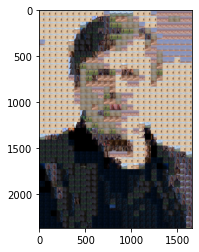

In [8]:
img = model.forward("example.jpg", "rectangle")
plt.imshow(img)

im = Image.fromarray(img)
im.save("rectangle.jpg")

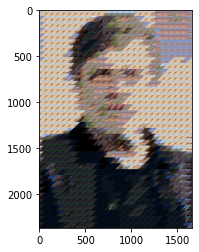

In [9]:
img = model.forward("example.jpg", "parallelogram")
plt.imshow(img)

im = Image.fromarray(img)
im.save("parallelogram.jpg")